# Asthma Machine Learning Pipeline

Notebook ini berisi pipeline lengkap untuk analisis dan modeling data asthma_disease_data.csv, yang mencakup:

1. Instalasi & Import Library
2. Load dataset
3. Exploratory Data Analysis (EDA)
4. Feature Engineering: Severity Scoring
5. Ordinal Classification: RandomForest Multi-Class
6. Model Testing & Evaluation
7. Explainable ML: Logistic Regression & SHAP
8. Clustering: KMeans & t-SNE
9. Visualization: Cluster vs Severity
10. Save Model

---

## 1. Instalasi & Import Library

In [ ]:
# Install library yang diperlukan langsung di notebook
%pip install pandas numpy matplotlib seaborn scikit-learn shap statsmodels

In [16]:
# Import library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import statsmodels.api as sm
import shap
import joblib

import warnings
warnings.filterwarnings('ignore')

# Atur style plot
sns.set(style="whitegrid")

## 2. Load Dataset

In [17]:
# Load data dari direktori ../dataset
# dan drop kolom yang tidak diperlukan

df = pd.read_csv('../dataset/asthma_disease_data.csv')
df.drop(columns=['PatientID', 'DoctorInCharge'], inplace=True)
df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
0,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,...,0,1.369051,4.941206,0,0,1,0,0,1,0
1,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,1.969838,...,0,2.197767,1.702393,1,0,0,1,1,1,0
2,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,...,0,1.698011,5.022553,1,1,1,0,1,1,0
3,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,...,0,3.032037,2.300159,1,0,1,1,1,0,0
4,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,0.980875,...,0,3.470589,3.067944,1,1,1,0,0,1,0


## 3. Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     2392 non-null   int64  
 1   Gender                  2392 non-null   int64  
 2   Ethnicity               2392 non-null   int64  
 3   EducationLevel          2392 non-null   int64  
 4   BMI                     2392 non-null   float64
 5   Smoking                 2392 non-null   int64  
 6   PhysicalActivity        2392 non-null   float64
 7   DietQuality             2392 non-null   float64
 8   SleepQuality            2392 non-null   float64
 9   PollutionExposure       2392 non-null   float64
 10  PollenExposure          2392 non-null   float64
 11  DustExposure            2392 non-null   float64
 12  PetAllergy              2392 non-null   int64  
 13  FamilyHistoryAsthma     2392 non-null   int64  
 14  HistoryOfAllergies      2392 non-null   

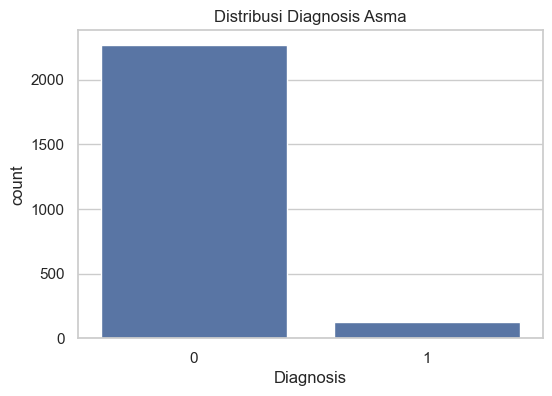

In [ ]:
# Tampilkan informasi dasar dan ringkasan statistik
df.info()

df.describe()

# Visualisasi distribusi target Diagnosis
plt.figure(figsize=(6,4))
sns.countplot(x='Diagnosis', data=df)
plt.title('Distribusi Diagnosis Asma')
plt.show()

## 4. Feature Engineering: Severity Scoring

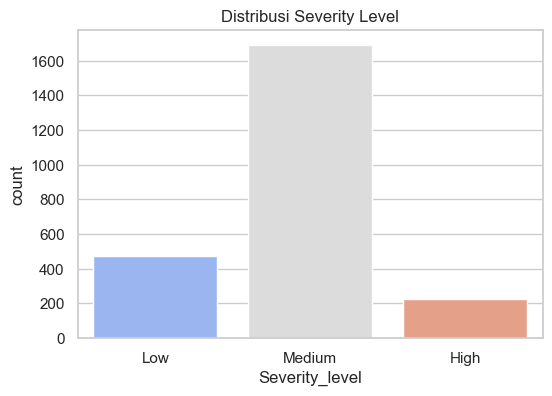

In [19]:
# Buat skor FEV1 (semakin rendah nilai FEV1, semakin tinggi skor)
df['FEV1_score'] = 1 - (df['LungFunctionFEV1'] / df['LungFunctionFEV1'].max())

# Hitung skor gejala sebagai proporsi gejala yang muncul
symptoms = ['Wheezing','ShortnessOfBreath','ChestTightness','Coughing','NighttimeSymptoms','ExerciseInduced']
df['Symptom_score'] = df[symptoms].sum(axis=1) / len(symptoms)

# Gabungkan menjadi severity score rata-rata
# (50% FEV1_score + 50% Symptom_score)
df['Severity_score'] = 0.5 * df['FEV1_score'] + 0.5 * df['Symptom_score']

# Kategorisasi menjadi Low/Medium/High
df['Severity_level'] = pd.cut(
    df['Severity_score'], bins=[0,0.33,0.66,1], labels=['Low','Medium','High'], include_lowest=True
)

# Tampilkan distribusi severity level
plt.figure(figsize=(6,4))
sns.countplot(x='Severity_level', data=df, palette='coolwarm')
plt.title('Distribusi Severity Level')
plt.show()

## 5. Ordinal Classification: RandomForest Multi-Class

Classification Report:
               precision    recall  f1-score   support

        High       1.00      0.96      0.98        45
         Low       1.00      0.97      0.98        95
      Medium       0.99      1.00      0.99       339

    accuracy                           0.99       479
   macro avg       1.00      0.97      0.98       479
weighted avg       0.99      0.99      0.99       479

Confusion Matrix:



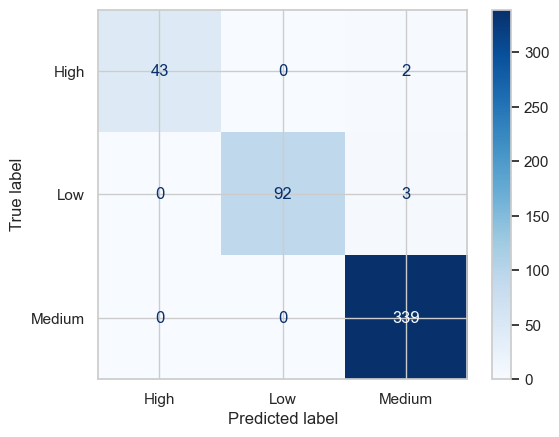

In [20]:
# Siapkan fitur dan target untuk klasifikasi multi-class
y = df['Severity_level']
X = df.drop(columns=['Severity_score','Severity_level'])

# Split train-test stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Pipeline: scaling + RandomForest
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning
param_grid = {
    'rf__n_estimators': [100,200],
    'rf__max_depth': [5,10,None]
}

grid_rf = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='f1_macro')
grid_rf.fit(X_train, y_train)

# Evaluasi model terbaik
y_pred = grid_rf.best_estimator_.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n")
ConfusionMatrixDisplay.from_estimator(grid_rf.best_estimator_, X_test, y_test, cmap='Blues')
plt.show()

## 6. Model Testing & Evaluation

In [28]:
# Cross-validation di train set untuk F1-macro scores
cv_scores = cross_val_score(
    grid_rf.best_estimator_, X_train, y_train, cv=5, scoring='f1_macro'
)
print(f"5-Fold CV Macro F1 Scores: {cv_scores}")
print(f"Mean CV Macro F1: {cv_scores.mean():.3f}")

# ROC-AUC multiclass One-vs-Rest
y_test_bin = label_binarize(y_test, classes=['Low','Medium','High'])
y_proba = grid_rf.best_estimator_.predict_proba(X_test)
roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"Multiclass ROC AUC (OvR): {roc_auc:.3f}")

5-Fold CV Macro F1 Scores: [0.9751462  0.97546314 0.96426782 0.96916451 0.97206627]
Mean CV Macro F1: 0.971
Multiclass ROC AUC (OvR): 0.188


In [ ]:
# Ambil model dan scaler dari pipeline
rf_model = grid_rf.best_estimator_.named_steps['rf']
scaler = grid_rf.best_estimator_.named_steps['scaler']

# Buat SHAP explainer dan transform data test
explainer = shap.TreeExplainer(rf_model)
X_test_scaled = scaler.transform(X_test)

# Hitung SHAP values (list of arrays untuk tiap class)
shap_values = explainer.shap_values(X_test_scaled)

# Plot summary plot untuk tiap kelas
for i, cls in enumerate(['Low','Medium','High']):
    print(f"SHAP Summary for class: {cls}")
    shap.summary_plot(shap_values[i], X_test_scaled, feature_names=X_test.columns)

## 8. Clustering: KMeans & t-SNE. Clustering: KMeans & t-SNE Clustering: KMeans & t-SNE Clustering: KMeans & t-SNE

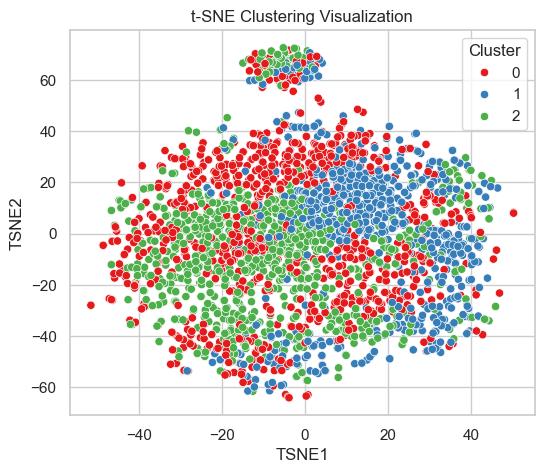

In [29]:
# Siapkan fitur untuk clustering
drop_cols = ['Severity_score','Severity_level','HighSeverity']
X_clust = df.drop(columns=drop_cols)
X_scaled = StandardScaler().fit_transform(X_clust)

# Tentukan cluster optimal via silhouette (contoh n_clusters=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

# Visualisasi dengan t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
df['TSNE1'], df['TSNE2'] = X_tsne[:,0], X_tsne[:,1]

plt.figure(figsize=(6,5))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=df, palette='Set1')
plt.title('t-SNE Clustering Visualization')
plt.show()

## 9. Visualization: Cluster vs Severity
Overlay severity pada hasil t-SNE clustering
- Custom palette: Low (blue), Medium (yellow), High (red) agar lebih jelas

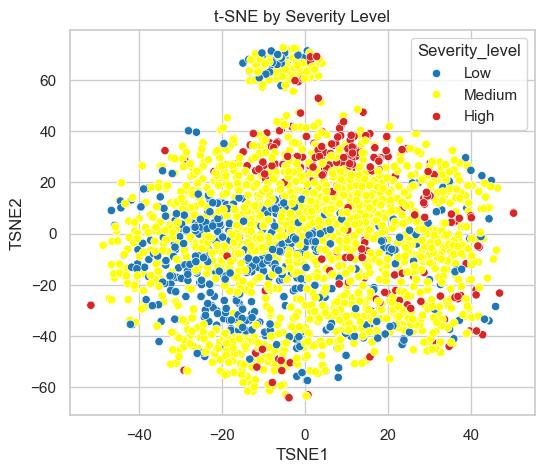

In [32]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='TSNE1', y='TSNE2', hue='Severity_level', data=df,
    palette={'Low':'#1f77b4','Medium':'yellow','High':'#d62728'}
)
plt.title('t-SNE by Severity Level')
plt.show()

## 10. Save Model

In [35]:
# Simpan model RandomForest terbaik untuk deployment
joblib.dump(grid_rf.best_estimator_, '../dataset/rf_severity_model.pkl')

['../dataset/rf_severity_model.pkl']